In [128]:
import random
from random import randint
import numpy as np
import csv
from datetime import datetime
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import pandas as pd
import matplotlib.pyplot as plt
import os

In [129]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [130]:
EPISODES = 2500

In [131]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # # Neural Net for Deep-Q learning Model
        # model = Sequential()
        # model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        # model.add(Dense(48, activation='relu'))
        # model.add(Dense(96, activation='relu'))
        # model.add(Dense(48, activation='relu'))
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(self.action_size, activation='linear'))
        # model.compile(loss='mse',
        #               optimizer=Adam(lr=self.learning_rate))
        # return model
        #     # Network defined by the Deepmind paper
        inputs = layers.Input(shape=(84, 84, 4,))

        # Convolutions on the frames on the screen
        layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
        layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
        layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

        layer4 = layers.Flatten()(layer3)

        layer5 = layers.Dense(512, activation="relu")(layer4)
        action = layers.Dense(num_actions, activation="linear")(layer5)

        return keras.Model(inputs=inputs, outputs=action)

    def remember(self, state, action, reward, next_state,collision_flag):
        self.memory.append((state, action, reward, next_state,collision_flag))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
      
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, collision_flag in minibatch:
            target = reward
            if not collision_flag:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [132]:
state_size = 1
action_size = 6
agent = DQNAgent(state_size, action_size)


batch_size = 32

now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
print(date_time)
directory = os.getcwd()
# path = r'E:\research\1103\Keras deep Q learning\result'
path = directory +'\\result'

fname = path +'\e_'+str(EPISODES)+'_' + date_time+'.csv'
print(fname)

with open(fname, mode='w+', newline='') as csv_file:
    fieldnames = ['episode', 'score', 'epsilon','collision','reward']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

01_04_2022_17_19_57
i:\Research\1229\traffic-q-learning\traffic-simulator-Q-learning-master\Keras deep Q learning\result\e_2500_01_04_2022_17_19_57.csv


In [133]:

for e in range(1,EPISODES+1):
    num_env_cars = randint(1,5) + 20;  # random car number
    eng.env_ini(num_env_cars,nargout=0)
    
    time = 0
    dist = 0
    score = 0
    ho_total = 1
  
    eng.deep_get_Observation(1,nargout=0)
    collision_flag=False

    bs_stat = eng.deepq_creat_bs(nargout=4)
    Xb = bs_stat[0]
    Yb = bs_stat[1]
    Xrb = bs_stat[2]
    Yrb = bs_stat[3]
    # print(bs_stat)    
    
    for time in range(1,201):


        state = eng.deep_obs2state(nargout=1)
    
        state = np.reshape(state, [1, state_size])
        
        eng.old_observation(nargout=0)
        
        action = agent.act(state)
        action=np.asscalar(np.int64(action))
            
        update_dynamic =eng.deepQ_update_dynamics(dist,action+1,Xb,Yb,Xrb,Yrb,nargout=2)
        dist = update_dynamic[0]
        ho = update_dynamic[1]
        ho_total = ho_total + ho
        HO_density = ho_total/ dist

        # print('ho density ',HO_density)

            
        collision_flag = eng.deep_check_collision(nargout=1)
            
        eng.deep_get_Observation(1,nargout=0)
            
        rewards_arr = eng.deep_get_reward(collision_flag,HO_density,nargout=4)
        # print(rewards_arr)
        r_transport = rewards_arr[0]  
        r_telecome = rewards_arr[1] 
        reward = rewards_arr[2]
        dr_ego = rewards_arr[3]
        # print('dr_ego ',dr_ego)
           
        next_state = eng.deep_obs2state(nargout=1)
            
        next_state = np.reshape(next_state, [1, state_size])
            
            
        agent.remember(state, action, reward, next_state,collision_flag)
            
            
        
        if collision_flag:

            break
    
    score = (dist-4000)/1000;    

 #  fieldnames = ['episode', 'score', 'epsilon','collision','telecome_reward','transport_reward','average_speed','ho_density','reward']
    print("episode: {}/{}, score: {}, e: {:.2}, Collision: {}, reward_tel: {}, reward_trans: {},average_speed:{},ho_density:{} reward: {}"
              .format(e, EPISODES, score, agent.epsilon,collision_flag,r_telecome,r_transport,dist/time,HO_density,reward))
    
    with open(fname,'a+' , newline='') as f:
        csv_write = csv.writer(f)
        row = [e, score, agent.epsilon,collision_flag,r_telecome,r_transport,dist/time,HO_density,reward]
        csv_write.writerow(row)
    
    
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
    if e % 10 == 0:
        agent.save("dqn.h5")
                
        

H:\Users\yanzi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


episode: 1/2500, score: -3.972, e: 1.0, Collision: True, reward_tel: 96.60828611234298, reward_trans: -996.0,average_speed:28.0,ho_density:0.07142857142857142 reward: -899.391713887657
episode: 2/2500, score: -3.97, e: 1.0, Collision: True, reward_tel: 46.35211066520278, reward_trans: -991.9,average_speed:30.0,ho_density:0.06666666666666667 reward: -945.5478893347972
episode: 3/2500, score: -3.974, e: 1.0, Collision: True, reward_tel: 247.2381637524542, reward_trans: -1000.0,average_speed:26.0,ho_density:0.07692307692307693 reward: -752.7618362475458
episode: 4/2500, score: -3.972, e: 1.0, Collision: True, reward_tel: 9.41733685534712, reward_trans: -995.4,average_speed:28.0,ho_density:0.07142857142857142 reward: -985.9826631446529
episode: 5/2500, score: -3.976, e: 1.0, Collision: True, reward_tel: 47.64445091168249, reward_trans: -1004.9,average_speed:24.0,ho_density:0.08333333333333333 reward: -957.2555490883175
episode: 6/2500, score: -3.975, e: 1.0, Collision: True, reward_tel: 45

                               episode   score  epsilon  collision  \
1    -3.972 1.000000 True    96.608286  -996.0    28.00   0.071429   
2    -3.970 1.000000 True    46.352111  -991.9    30.00   0.066667   
3    -3.974 1.000000 True   247.238164 -1000.0    26.00   0.076923   
4    -3.972 1.000000 True     9.417337  -995.4    28.00   0.071429   
5    -3.976 1.000000 True    47.644451 -1004.9    24.00   0.083333   
6    -3.975 1.000000 True   451.857604 -1002.9    25.00   0.080000   
7    -3.972 1.000000 True    38.294046  -996.9    28.00   0.071429   
8    -3.975 1.000000 True   656.226830 -1002.0    25.00   0.080000   
9    -3.976 1.000000 True   139.497997 -1004.0    24.00   0.083333   
10   -3.980 1.000000 True   219.768470 -1010.9    20.00   0.100000   
11   -3.974 1.000000 True    38.042158  -997.4    26.00   0.076923   
12   -3.979 1.000000 True   102.625464 -1010.9    21.00   0.095238   
13    0.814 1.000000 False  245.758214     6.4    24.07   0.002908   
14   -3.979 0.995000

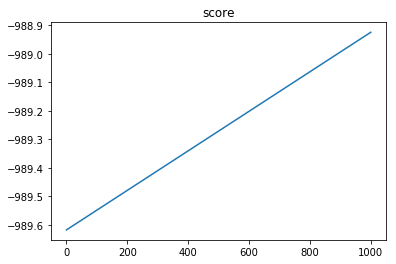

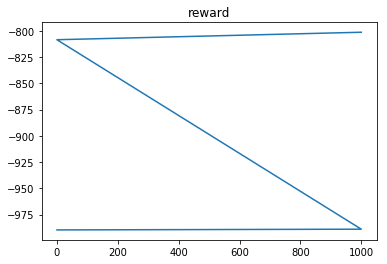

In [134]:

directory = os.getcwd()
path = directory +'\\result\\'
df = pd.read_csv(fname)  
print(df)
bin_num = 1000
x =[]
y= []
i= 'score'
# EPISODES = 1000
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")
plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

i= 'reward'
# EPISODES = 1000
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")

plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

In [135]:

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'E:\research\1103\Keras deep Q learning\e_1000_12_13_2021_18_08_30.csv')  

print(df)
bin_num = 20 
x =[]
y= []
i= 'reward'
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")
plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

FileNotFoundError: File b'E:\\research\\1103\\Keras deep Q learning\\e_1000_12_13_2021_18_08_30.csv' does not exist

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'E:\research\1120\traffic-simulator-Q-learning-master\Parameters\score_alpha_0.2_episode_10000_w5_0.1_epsilon_decay_v2.csv')  
print(df)
bin_num = 500 
x =[]
y= []
i= 'reward'
for j in range(int(EPISODES/bin_num)):
        x.append(j * bin_num)
        y.append(df[j * bin_num:j * bin_num+(bin_num-1)][i].mean())
plt.title(i)
# plt.legend(i + "_mean")
plt.plot(x, y , label = "v=20")
plt.savefig(path + i +date_time + str(bin_num) +'.png')
plt.show()

      -3.5695
0     -3.9100
1     -3.8595
2     -3.7555
3     -3.6320
4     -3.8850
...       ...
9994   0.8540
9995  -3.1020
9996   1.3600
9997   1.4355
9998   0.7840

[9999 rows x 1 columns]


KeyError: 'reward'